# NASDAQ One Week Performance Predictor

In [1]:
import nasdaqdatalink
import yfinance as yf
import requests as rq
import pandas as pd
import bs4 as bs
import time
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from dotenv import load_dotenv
load_dotenv()
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from contextlib import suppress
from sklearn.neural_network import MLPClassifier
from datetime import timedelta
from gensim.models import word2vec
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import json
import os
import random

[nltk_data] Downloading package stopwords to /Users/skdod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/skdod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2022-12-18 18:49:13.564193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Part 1 - Data Wrangling

In [2]:
df = pd.read_csv('./dataframe.csv', index_col='Unnamed: 0')

In [3]:
df.count()

highlights         521
published_at       521
gain               521
sentiment            1
sentiment_score      1
dtype: int64

In [4]:
minLen = float('inf')
for highlight in df['highlights']:
    if len(highlight) < minLen:
        minLen = len(highlight)
print(minLen)

33


In [5]:
# Import the list of valid NASDAQ tickers
nasdaq_tickers = pd.read_json('../nasdaq_tickers.json').ticker.tolist()

In [6]:
# Get index data for the year
pastWeekDate = str(datetime.datetime.today() - datetime.timedelta(days=8))[0:10]
pastYearDate = str(datetime.datetime.today() - datetime.timedelta(days=372))[0:10]
ivv = yf.download('IVV', start=pastYearDate, end=pastWeekDate)

[*********************100%***********************]  1 of 1 completed


In [7]:
responseObj={}

In [8]:
try:
    df
except:
    df = pd.DataFrame()

In [9]:
marketaux = os.getenv('MARKETAUX_ACCESS_KEY')
startTime = datetime.datetime.today()

currentSamples = 0
sampleCount = 100

# Here we check for total number of positive and negative samples, as each is 
#     capped at sampleCount.
while (sampleCount > currentSamples):
    print('currentSamples: ',currentSamples)
    currentTicker = nasdaq_tickers[random.randint(0,len(nasdaq_tickers)-1)]
    try:
        currentTicker not in df.index
    except:
        print('continue')
        continue
    try:
        print('ran next')
        response = rq.get("https://api.marketaux.com/v1/news/all?symbols=" \
            +str(currentTicker) \
            +"&filter_entities=true&language=en&published_before="+pastWeekDate \
            +"&published_after="+ pastYearDate +"&api_token="+str(marketaux))
        temp = response.json()
        for data in temp['data']:
            for entity in data['entities']:
                if currentTicker == entity['symbol']:
                    if entity['symbol'] not in responseObj:
                        responseObj[entity['symbol']] = {}
                        responseObj[entity['symbol']]['highlights'] = ''
                        maxWords = 0
                        for count, highlight in enumerate(entity['highlights']):
                            try:
                                if responseObj[entity['symbol']]['published_at'] != data['published_at'].split('T')[0]:
                                    if len(highlight) > maxWords:
                                        maxWords = len(highlight)
                                        responseObj[entity['symbol']]['published_at'] = \
                                            data['published_at'].split('T')[0]
                                        responseObj[entity['symbol']]['highlights'] += highlight['highlight']
                                        responseObj[entity['symbol']]['sentiment'] += entity['sentiment']
                                    else:
                                        continue
                            except:
                                maxWords = len(highlight)
                                responseObj[entity['symbol']]['published_at'] = \
                                    data['published_at'].split('T')[0]
                                responseObj[entity['symbol']]['highlights'] += highlight['highlight']
                                responseObj[entity['symbol']]['sentiment'] += entity['sentiment']
        currentSamples += 1
        sleep(.1)
    except:
        print(response)
        continue
datetime.datetime.today() - startTime

currentSamples:  0
ran next
<Response [200]>
currentSamples:  0
ran next
<Response [200]>
currentSamples:  0
ran next
<Response [200]>
currentSamples:  1
ran next
<Response [200]>
currentSamples:  1
ran next
<Response [200]>
currentSamples:  2
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  3
ran next
<Response [200]>
currentSamples:  4
ran next
<Response [200]>
currentSamples:  5
ran next
<Response [200]>
currentSamples:  5
ran next
<Response [200]>
currentSamples:  6
ran next
<Response [200]>
currentSamples:  6
ran next
<Response [200]>
currentSamples:  7
ran next
<Response [200]>
currentSamples:  8
ran next
<Response [200]>
currentSamples:  8
ran next
<Response [200]>
currentSam

<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  20
ran next
<Response [429]>
currentSamples:  

<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  43
ran next
<Response [429]>
currentSamples:  

<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  66
ran next
<Response [429]>
currentSamples:  

<Response [200]>
currentSamples:  79
ran next
<Response [200]>
currentSamples:  79
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  80
ran next
<Response [200]>
currentSamples:  81
ran next
<Response [200]>
currentSamples:  81
ran next
<Response [200]>
currentSamples:  81
ran next
<Response [200]>
currentSamples:  82
ran next
<Response [200]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  82
ran next
<Response [429]>
currentSamples:  

<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  85
ran next
<Response [200]>
currentSamples:  86
ran next
<Response [200]>
currentSamples:  86
ran next
<Response [200]>
currentSamples:  86
ran next
<Response [200]>
currentSamples:  86
ran next
<Response [200]>
currentSamples:  86
ran next
<Response [200]>
currentSamples:  86
ran next
<Response [200]>
currentSamples:  87
ran next
<Response [200]>
currentSamples:  88
ran next
<Response [200]>
currentSamples:  88
ran next
<Response [200]>
currentSamples:  89
ran next
<Response [200]>
currentSamples:  89
ran next
<Response [200]>
currentSamples:  89
ran next
<Response [200]>
currentSamples:  

datetime.timedelta(seconds=268, microseconds=736111)

In [10]:
highlightsObj = {}
for currentTicker in responseObj.keys():
    if len(responseObj[currentTicker]['highlights']):
        highlightsObj[currentTicker] = responseObj[currentTicker]
for currentTicker in highlightsObj.keys():
    print(currentTicker)
    try:
        publishDate = highlightsObj[currentTicker]['published_at']
        weekAfterPublishDate = \
            str(datetime.datetime.strptime(publishDate, \
            '%Y-%m-%d').date() + timedelta(days=7))[0:10]
        ivvWeekPerf = ivv.loc[weekAfterPublishDate]['Close'] - ivv.loc[publishDate]['Close']
        response = yf.download(currentTicker, start=datetime.datetime.strptime(publishDate, '%Y-%m-%d'), \
            end=datetime.datetime.strptime(weekAfterPublishDate, '%Y-%m-%d') + timedelta(days=1))
        response.index = response.index.astype('string')
        final_price = response.loc[response.index[0]]['Close']
        start_price = response.loc[publishDate]['Close']
        # This is the percent gain or loss you would classify as an actual gain. For instance,
        # we wouldn't want to classify a 
        marginal_gain_or_loss = 1
        performance = (final_price - start_price) - ivvWeekPerf
        if performance >= (marginal_gain_or_loss / 100) * start_price:
            highlightsObj[currentTicker]['gain'] = 'positive'
        elif performance <= -(marginal_gain_or_loss / 100) * start_price:
            highlightsObj[currentTicker]['gain'] = 'negative'
        else:
            highlightsObj[currentTicker]['gain'] = 'trivial'
        print(highlightsObj[currentTicker]['gain'])
    except:
        try:
            publishDate = highlightsObj[currentTicker]['published_at']
            weekAfterPublishDate = \
                str(datetime.datetime.strptime(publishDate, \
                '%Y-%m-%d').date() + timedelta(days=8))[0:10]
            ivvWeekPerf = ivv.loc[weekAfterPublishDate]['Close'] - ivv.loc[publishDate]['Close']
            response = yf.download(currentTicker, start=datetime.datetime.strptime(publishDate, '%Y-%m-%d'), \
                end=datetime.datetime.strptime(weekAfterPublishDate, '%Y-%m-%d') + timedelta(days=1))
            response.index = response.index.astype('string')
            final_price = response.loc[response.index[0]]['Close']
            start_price = response.loc[publishDate]['Close']
            # This is the percent gain or loss you would classify as an actual gain. For instance,
            # we wouldn't want to classify a 
            marginal_gain_or_loss = 1
            performance = (final_price - start_price) - ivvWeekPerf
            if performance >= (marginal_gain_or_loss / 100) * start_price:
                highlightsObj[currentTicker]['gain'] = 'positive'
            elif performance <= -(marginal_gain_or_loss / 100) * start_price:
                highlightsObj[currentTicker]['gain'] = 'negative'
            else:
                highlightsObj[currentTicker]['gain'] = 'trivial'
            print(highlightsObj[currentTicker]['gain'])
        except:
            try:
                publishDate = highlightsObj[currentTicker]['published_at']
                weekAfterPublishDate = \
                    str(datetime.datetime.strptime(publishDate, \
                    '%Y-%m-%d').date() + timedelta(days=9))[0:10]
                ivvWeekPerf = ivv.loc[weekAfterPublishDate]['Close'] - ivv.loc[publishDate]['Close']
                response = yf.download(currentTicker, start=datetime.datetime.strptime(publishDate, '%Y-%m-%d'), \
                    end=datetime.datetime.strptime(weekAfterPublishDate, '%Y-%m-%d') + timedelta(days=1))
                response.index = response.index.astype('string')
                final_price = response.loc[response.index[0]]['Close']
                start_price = response.loc[publishDate]['Close']
                # This is the percent gain or loss you would classify as an actual gain. For instance,
                # we wouldn't want to classify a 
                marginal_gain_or_loss = 1
                performance = (final_price - start_price) - ivvWeekPerf
                if performance >= (marginal_gain_or_loss / 100) * start_price:
                    highlightsObj[currentTicker]['gain'] = 'positive'
                elif performance <= -(marginal_gain_or_loss / 100) * start_price:
                    highlightsObj[currentTicker]['gain'] = 'negative'
                else:
                    highlightsObj[currentTicker]['gain'] = 'trivial'
                print(highlightsObj[currentTicker]['gain'])
            except:
                try:
                    publishDate = highlightsObj[currentTicker]['published_at']
                    weekAfterPublishDate = \
                        str(datetime.datetime.strptime(publishDate, \
                        '%Y-%m-%d').date() + timedelta(days=10))[0:10]
                    ivvWeekPerf = ivv.loc[weekAfterPublishDate]['Close'] - ivv.loc[publishDate]['Close']
                    response = yf.download(currentTicker, start=datetime.datetime.strptime(publishDate, '%Y-%m-%d'), \
                        end=datetime.datetime.strptime(weekAfterPublishDate, '%Y-%m-%d') + timedelta(days=1))
                    response.index = response.index.astype('string')
                    print(response)
                    final_price = response.loc[response.index[0]]['Close']
                    start_price = response.loc[publishDate]['Close']
                    # This is the percent gain or loss you would classify as an actual gain. For instance,
                    # we wouldn't want to classify a 
                    marginal_gain_or_loss = 1
                    performance = (final_price - start_price) - ivvWeekPerf
                    if performance >= (marginal_gain_or_loss / 100) * start_price:
                        highlightsObj[currentTicker]['gain'] = 'positive'
                    elif performance <= -(marginal_gain_or_loss / 100) * start_price:
                        highlightsObj[currentTicker]['gain'] = 'negative'
                    else:
                        highlightsObj[currentTicker]['gain'] = 'trivial'
                    print(highlightsObj[currentTicker]['gain'])
                except:
                    try:
                        print('bad response', response.json())
                    except:
                        print('could not print response')
                continue

STNG
bad response {'meta': {'found': 0, 'returned': 0, 'limit': 50, 'page': 1}, 'data': []}
OGS
bad response {'meta': {'found': 0, 'returned': 0, 'limit': 50, 'page': 1}, 'data': []}
GGG
bad response {'meta': {'found': 0, 'returned': 0, 'limit': 50, 'page': 1}, 'data': []}
ONE
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ONE: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ONE: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ONE: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ONE: No data found for this date range, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
could not print response
ST

[*********************100%***********************]  1 of 1 completed
positive
KAMN
[*********************100%***********************]  1 of 1 completed
positive
EHTH
could not print response
RM
[*********************100%***********************]  1 of 1 completed
negative
NOV
could not print response
HALL
[*********************100%***********************]  1 of 1 completed
negative
MBII
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MBII: No data found for this date range, symbol may be delisted
could not print response
ACN
could not print response
WEYS
could not print response
FLT
[*********************100%***********************]  1 of 1 completed
negative
HBIO
could not print response
SYY
could not print response
IRBT
could not print response
HY
could not print response
D
could not print response
SALT
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SALT: No data found for this date range, symbol ma

[*********************100%***********************]  1 of 1 completed
positive
APTV
could not print response
NKTR
[*********************100%***********************]  1 of 1 completed
positive
AHH
could not print response
EGY
could not print response
TDY
could not print response
COO
could not print response
BECN
[*********************100%***********************]  1 of 1 completed
negative
STFC
could not print response
ATRO
could not print response
ACET
could not print response
MKL
[*********************100%***********************]  1 of 1 completed
trivial
STR
[*********************100%***********************]  1 of 1 completed
negative
GOOD
[*********************100%***********************]  1 of 1 completed
negative
XRX
[*********************100%***********************]  1 of 1 completed
positive
ANSS
could not print response
MRC
[*********************100%***********************]  1 of 1 completed
positive
CCMP
could not print response
MNRO
could not print response
WEN
could not print 

In [11]:
temp_df = pd.DataFrame(responseObj.values(), responseObj.keys())
temp_df.dropna(inplace=True)

In [12]:
try:
    df = df[df['highlights'].map(lambda d: len(d)) > 0]
    df = df.append(temp_df)
except:
    df=temp_df

In [13]:
df = df[~df.index.duplicated(keep='first')]

In [14]:
df.to_csv('./dataframe.csv', sep=',')

In [15]:
df.count()

highlights         550
published_at       550
gain               550
sentiment            1
sentiment_score      1
dtype: int64

In [16]:
df.head()

,highlights,published_at,gain,sentiment,sentiment_score
PCRX,<em>Pacira</em> <em>BioSciences</em> reports s...,2022-11-14,positive,NaN,NaN
FET,<em>Forum</em> <em>Energy</em> <em>Technologie...,2022-11-09,negative,NaN,NaN
TISI,Consolidated Revenue Increased 10% over 3Q 202...,2022-11-08,negative,NaN,NaN
RCII,"<em>Rent</em>-<em>A</em>-<em>Center</em>, <em>...",2022-11-09,negative,NaN,NaN
ACTG,<em>Acacia</em> <em>Research</em> <em>Corporat...,2022-11-10,positive,NaN,NaN


# Part 2 - EDA

In [22]:
# Tokenize the highlights
start = datetime.datetime.now()
text_len_arr = []
print(df.index)
for idx, row in df.iterrows():
    if isinstance(row['highlights'], str):
        tokens = nltk.word_tokenize(row['highlights'])
        formatted_tokens = [word.lower() for word in tokens \
        if word.lower() not in ['january','february','march', \
        'april','may', 'june','july','august','september', \
        'october', 'november','december','sunday','monday',\
        'tuesday', 'wednesday','thursday','friday','saturday',
        'inc','company','nasdaq', 'nyse','corporation']\
        and word.lower() not in stopwords.words('english') \
        and word.isalpha() and word != idx and len(word) > 2]
        df['highlights'][idx] = formatted_tokens
        print('ran formatted')
        text_len_arr.append(len(formatted_tokens))
    else:
        text_len_arr.append(len(row['highlights']))
print('runtime: ' + str(datetime.datetime.now() - start))

Index(['PCRX', 'FET', 'TISI', 'RCII', 'ACTG', 'CFFN', 'CWH', 'WU', 'BZH',
       'CHCO',
       ...
       'FN', 'PRGO', 'NAVB', 'AVEO', 'ESI', 'NKTR', 'MKL', 'GOOD', 'MRC',
       'SNCR'],
      dtype='object', length=550)
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted


/var/folders/qp/hgh__lqs1dz1wk35m_9mqmn40000gn/T/ipykernel_48049/2842780824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['highlights'][idx] = formatted_tokens


ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran formatted
ran fo

,highlights,published_at,gain,sentiment,sentiment_score
PCRX,"[pacira, biosciences, reports, sales]",2022-11-14,positive,NaN,NaN
FET,"[forum, energy, technologies]",2022-11-09,negative,NaN,NaN
TISI,"[consolidated, revenue, increased, completes, ...",2022-11-08,negative,NaN,NaN
RCII,"[rent, center]",2022-11-09,negative,NaN,NaN
ACTG,"[acacia, research, earnings, conference, call,...",2022-11-10,positive,NaN,NaN


In [23]:
df.groupby('gain').count()

,highlights,published_at,sentiment,sentiment_score
gain,,,,
negative,349,349,0,0
positive,198,198,1,1
trivial,3,3,0,0


(array([ 32.,  49.,  26.,  45.,  75., 119., 114.,  56.,  25.,   9.]),
 array([ 1. ,  4.9,  8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 36.1, 40. ]),
 <BarContainer object of 10 artists>)

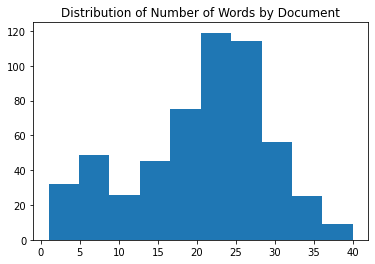

In [24]:
plt.title('Distribution of Number of Words by Document')
plt.hist(text_len_arr)

In [25]:
# Maximum number of tokens
max_len = np.max(text_len_arr)
max_len

40

In [26]:
# Minimum number of tokens
min_len = np.min(text_len_arr)
min_len

1

In [27]:
# Count the number of occurrences by word among all docs
occurrencesInDocs = {}
for text in df['highlights']:
    for word in set(text):
        try: occurrencesInDocs[word] += 1
        except: occurrencesInDocs[word] = 1

In [28]:
# reduced_obj = {}
# reduced_text_len = []
# text_arr_len = []
# for item,occurrences in occurrencesInDocs.items():
#     if occurrences > .6 * len(responseObj) or occurrences < .03 * len(responseObj):
#         for idx,text in df['highlights']:
#             temp = []
#             for word in text:
#                 if word != item:
#                     temp.append(word)
#             if len(temp) > 100:
#                 reduced_obj[idx] = temp
#                 reduced_text_len.append(len(temp))
#                 text_arr_len.append(len(text_obj[idx]))

In [29]:
# Sort occurrencesInDocs by number of occurrences
occurrencesInDocsSorted = sorted(occurrencesInDocs.items(), key=lambda x: x[1], reverse=True)

<BarContainer object of 20 artists>

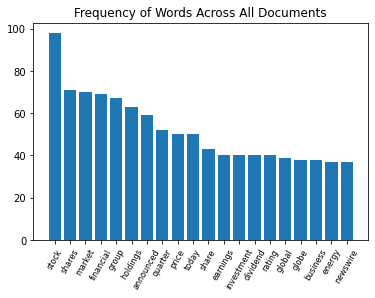

In [30]:
plt.xticks(rotation=60, fontsize=8)
plt.title('Frequency of Words Across All Documents')
plt.bar([x[0] for x in occurrencesInDocsSorted][0:20], [x[1] for x in occurrencesInDocsSorted][0:20])

In [31]:
corpus = {}

start = datetime.datetime.now()

for idx, text in df.iterrows():
    with suppress(FutureWarning):
        for word in text['highlights']:
            try:
                corpus[word] += 1
            except:
                corpus[word] = 1
            
print('runtime: ' + str(datetime.datetime.now() - start))

runtime: 0:00:00.068671


In [32]:
corpus_sorted = sorted(corpus.items(), key=lambda x: int(x[1]), reverse = True)

In [33]:
corpus_sorted

[('stock', 113),
 ('shares', 111),
 ('financial', 86),
 ('group', 85),
 ('market', 76),
 ('quarter', 73),
 ('price', 68),
 ('holdings', 68),
 ('announced', 63),
 ('rating', 61),
 ('call', 55),
 ('conference', 52),
 ('today', 51),
 ('traded', 51),
 ('energy', 50),
 ('dividend', 48),
 ('share', 45),
 ('investment', 44),
 ('corp', 43),
 ('earnings', 42),
 ('global', 41),
 ('services', 41),
 ('growth', 39),
 ('per', 39),
 ('business', 38),
 ('globe', 38),
 ('industries', 38),
 ('get', 38),
 ('technology', 38),
 ('newswire', 37),
 ('results', 37),
 ('new', 37),
 ('participants', 36),
 ('capital', 36),
 ('management', 35),
 ('average', 35),
 ('portfolio', 35),
 ('ltd', 35),
 ('technologies', 34),
 ('president', 34),
 ('year', 34),
 ('chief', 33),
 ('officer', 33),
 ('bank', 33),
 ('report', 31),
 ('limited', 30),
 ('international', 30),
 ('trading', 29),
 ('companies', 29),
 ('llc', 28),
 ('solutions', 28),
 ('incorporated', 28),
 ('stocks', 27),
 ('equity', 27),
 ('million', 27),
 ('systems

In [34]:
train_target = df['gain'][0:int(.6*df.highlights.count())]

In [35]:
tf_corpus_train = []
tf_corpus_test = []

start = datetime.datetime.now()
train_test_split_index = int(.6*len(df))
for text in df['highlights'][0:train_test_split_index]:
    print(text)
    tf_corpus_train.append(text)
for text in df['highlights'][train_test_split_index:]:
    print(text)
    tf_corpus_test.append(text)
    
print('runtime: ' + str(datetime.datetime.now() - start))

['pacira', 'biosciences', 'reports', 'sales']
['forum', 'energy', 'technologies']
['consolidated', 'revenue', 'increased', 'completes', 'strategic', 'sale', 'quest', 'integrity', 'business', 'baker', 'hughes', 'sugar', 'land', 'texas', 'globe', 'newswire', 'team']
['rent', 'center']
['acacia', 'research', 'earnings', 'conference', 'call', 'participants', 'rob', 'fink', 'fnk', 'martin', 'mcnulty', 'interim', 'ceo', 'richard', 'rosenstein', 'cfo', 'conference', 'call', 'participants', 'anthony', 'stoss', 'brett', 'reiss', 'janney', 'adam', 'eagleston', 'formidable', 'asset', 'management', 'operator', 'good', 'morning']
['capitol', 'federal', 'financial', 'trade', 'capitol', 'federal', 'financial', 'executive', 'vice', 'president', 'rick', 'jackson', 'acquired', 'total', 'shares', 'average', 'price', 'acquire', 'shares', 'cost', 'around', 'thousand', 'executive', 'vice', 'president', 'rick', 'jackson', 'acquired', 'total', 'shares', 'average', 'price']
['camping', 'world', 'holdings', 'ca

# Part 2 - TFIDF Model

In [36]:
corpusLen=[]
for corpus in tf_corpus_train:
    corpusLen.append(len(corpus))
corpusMin = np.min(corpusLen)

In [37]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=100)
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english', max_features=100)

In [38]:
tf_strings = [' '.join(x[1]) for x in df['highlights'].items()]
tf_strings_train = tf_strings[0:train_test_split_index]
tf_strings_test = tf_strings[train_test_split_index:]

In [39]:
tf_strings_train

['pacira biosciences reports sales',
 'forum energy technologies',
 'consolidated revenue increased completes strategic sale quest integrity business baker hughes sugar land texas globe newswire team',
 'rent center',
 'acacia research earnings conference call participants rob fink fnk martin mcnulty interim ceo richard rosenstein cfo conference call participants anthony stoss brett reiss janney adam eagleston formidable asset management operator good morning',
 'capitol federal financial trade capitol federal financial executive vice president rick jackson acquired total shares average price acquire shares cost around thousand executive vice president rick jackson acquired total shares average price',
 'camping world holdings camping world america recreation dealer today announced tamara ward retire position chief operating officer effective',
 'western union western union global leader money movement payments western union platform provides seamless flows leading global financial net

In [40]:
count_wm = count_vectorizer.fit_transform(tf_strings_train)
tfidf_wm = vectorizer.fit_transform(tf_strings_train)

In [41]:
tfidf_tokens = vectorizer.get_feature_names()

In [42]:
list(zip(tfidf_tokens, vectorizer.idf_))

[('add', 5.415824014257172),
 ('america', 4.163061045761804),
 ('american', 4.604893798040844),
 ('announced', 3.1132389212631266),
 ('article', 4.722676833697227),
 ('average', 3.806386101823072),
 ('bancorp', 4.237169017915527),
 ('bank', 4.237169017915527),
 ('board', 4.499533282383018),
 ('bought', 4.604893798040844),
 ('business', 3.806386101823072),
 ('buy', 4.317211725589063),
 ('cap', 4.094068174274852),
 ('capital', 3.806386101823072),
 ('ceo', 4.237169017915527),
 ('cfo', 4.499533282383018),
 ('chief', 3.806386101823072),
 ('companies', 4.094068174274852),
 ('conference', 3.624064545029117),
 ('corp', 3.806386101823072),
 ('development', 4.499533282383018),
 ('directors', 4.499533282383018),
 ('dividend', 3.5832425505088623),
 ('earnings', 3.5832425505088623),
 ('energy', 3.666624159447913),
 ('equity', 3.806386101823072),
 ('executive', 4.029529653137281),
 ('financial', 3.0409182596835005),
 ('firm', 4.404223102578692),
 ('fund', 4.404223102578692),
 ('getty', 4.40422310257

Combine models for text and then create a model for data, then combine the inputs together into deep neural network. Model Merging

# Part 4 - Model

In [43]:
mlp = MLPClassifier()
mlp_grid = {
    'hidden_layer_sizes': [3,5,8,20,40,80,100,120,160,200],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}
mlp_params = RandomizedSearchCV(
    estimator = mlp, 
    param_distributions=mlp_grid,
    n_iter = 200, 
    cv = 3, 
    verbose = 2, 
    random_state = 42, 
    n_jobs = -1
)
mlp_params.fit(vectorizer.transform(tf_strings_train), df.gain[0:train_test_split_index].astype(str))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilaye

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converg

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converg

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilaye

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: M

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilaye

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilaye

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converg

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converg

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converg

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anacond

RandomizedSearchCV(cv=3, estimator=MLPClassifier(), n_iter=200, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [3, 5, 8, 20, 40,
                                                               80, 100, 120,
                                                               160, 200],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=42, verbose=2)

In [44]:
best_params = mlp_params.best_params_
best_params

{'solver': 'adam',
 'learning_rate': 'constant',
 'hidden_layer_sizes': 120,
 'activation': 'logistic'}

In [45]:
with suppress(FutureWarning):
    mlp = MLPClassifier(
        solver=best_params['solver'], 
        learning_rate=best_params['learning_rate'], 
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation']

    )
    classifier = make_pipeline(vectorizer, mlp)

    # Get cross-validated accuracy of the model
    cv_accuracy = cross_val_score(classifier, tf_strings_train, df.gain[0:train_test_split_index].astype(str), cv=5)
    print("Mean Accuracy: {}".format(np.mean(cv_accuracy)))

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Accuracy: 0.7030303030303029


/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
test_target = df['gain'][train_test_split_index:]

In [47]:
mlp = MLPClassifier(
        solver=best_params['solver'], 
        learning_rate=best_params['learning_rate'], 
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation']

    )
mlp.fit(vectorizer.transform(tf_strings_train), df.gain[0:train_test_split_index].astype(str))
predictions = mlp.predict(vectorizer.transform(tf_strings_test))

/Users/skdod/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
correctPredictions = []
for idx,item in enumerate(list(zip(predictions,test_target))):
    print(item)
    if item[0] == str(item[1]):
        correctPredictions.append(idx)

('negative', 'negative')
('negative', 'positive')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'positive')
('negative', 'negative')
('positive', 'negative')
('negative', 'negative')
('positive', 'positive')
('negative', 'negative')
('negative', 'positive')
('negative', 'negative')
('negative', 'negative')
('negative', 'positive')
('negative', 'negative')
('negative', 'negative')
('positive', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'positive')
('negative', 'positive')
('negative', 'negative')
('negative', 'positive')
('negative', 'negative')
('positive', 'negative')
('negative', 'positive')
('positive', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'positive')
('negative', 'positive')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')
('negative', 'negative')


In [49]:
len(correctPredictions) / len(predictions)

0.5136363636363637

In [50]:
correctPredictions

[0,
 2,
 3,
 4,
 6,
 8,
 9,
 10,
 12,
 13,
 15,
 16,
 18,
 19,
 22,
 24,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 48,
 51,
 53,
 56,
 59,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 74,
 76,
 82,
 83,
 84,
 85,
 87,
 92,
 93,
 94,
 95,
 97,
 98,
 99,
 100,
 102,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 116,
 117,
 119,
 120,
 121,
 124,
 126,
 127,
 128,
 129,
 130,
 132,
 133,
 134,
 136,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 148,
 149,
 151,
 152,
 155,
 156,
 162,
 166,
 167,
 178,
 198,
 199,
 200,
 203,
 205,
 207,
 208,
 212,
 217]

In [51]:
pd.Series(test_target).value_counts()

negative    117
positive    100
trivial       3
Name: gain, dtype: int64

In [52]:
pd.Series(predictions).value_counts()

negative    196
positive     24
dtype: int64

In [53]:
list(zip(predictions,test_target))

[('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('positive', 'negative'),
 ('negative', 'negative'),
 ('positive', 'positive'),
 ('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('positive', 'negative'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('positive', 'negative'),
 ('negative', 'positive'),
 ('positive', 'negative'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'positive'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 ('negative', 'negative'),
 

In [54]:

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
for i in len(train_target):
    if train_target[i] == True:
        train_target[i] = 1
    else:
        train_target[i] = 0
for idx, item in enumerate(df[0:int(.6*len(data_train))]['text']):
    logreg.fit(item, train_target[idx])

%%time

y_pred = logreg.predict(data_train[0:int(.6*len(data_train))])

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

TypeError: 'int' object is not iterable